### 모두를 위한 딥러닝 강좌
  - ML lab 09-2 : Tensorboard(Neural Net for XOR) : http://bit.ly/2yfiC81

### TensorBoard : TF loggin/debuggin tool
  - Visualize your TF graph
  - Plot quantitative metrics(수치매트릭스)
  - Show additional data
  - Add tf.name_scope for better graph hierarchy

### 5 steps of using TensorBoard
  1. From TF graph, decide which tensors you want to log
  2. Merge all summaries
  3. Create writer and add graph
  4. Run summary merge and add_summary
  5. Launch Tensorboard(Default: http://localhost:6006)

### Multiple runs
  - FileWriter에서 하위 경로를 다르게 해서 두개의 log를 남긴다.
  - logdir 을 parent directory 로 실행
  ```python
  writer = tf.summary.FileWriter("./logs/xor_logs")
  writer = tf.summary.FileWriter("./logs/xor_logs_r0_01")
  ```
  $tensorboard -logdir=./logs
  
### tensorflow summary operations ( http://bit.ly/2yeB0xO )
  - Writing Summaries : FileWriter, FileWriterCache
  - Summary Ops
    * tf.summary.tensor_summary : Outputs a Summary protocol buffer with a serialized tensor
    * tf.summary.scalar : Outputs a Summary protocol buffer containing a single scalar value
    * tf.summary.histogram : The generated Summary has one summary value containing a histogram for values. Adding a histogram summary makes it possible to visualize your data's distribution in TensorBoard
    * tf.summary.audio : Outputs a Summary protocol buffer with audio. The summary has up to max_outputs summary values containing audio
    * tf.summary.image : Outputs a Summary protocol buffer with images. The summary has up to max_outputs summary values containing images
    * tf.summary.merge : Merges summaries. This op creates a Summary protocol buffer that contains the union of all the values in the input summaries.
    * tf.summary.merge_all : Merges all summaries collected in the default graph
  

## Sample 1

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
tf.set_random_seed(777) # reproductibility

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# hyper parameters
learning_rate = 0.001
epochs = 15
batch_size = 100
tb_summary_dir = './tb/mnist'

In [5]:
print(int(mnist.train.num_examples))
print(batch_size)
print(int(mnist.train.num_examples / batch_size)) # 550

55000
100
550


In [6]:
# input
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

x_image = tf.reshape(X, [-1, 28, 28, 1])
tf.summary.image('input', x_image, 3)  # name : tensor, 3 : interpreted as RGB

# dropout_rate
keep_prob = tf.placeholder(tf.float32)

In [7]:
with tf.variable_scope('layer1') as scope:
    W1 = tf.get_variable("W", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.random_normal([512]))
    L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
    
    tf.summary.histogram("X", X)
    tf.summary.histogram("weights", W1)
    tf.summary.histogram("bias", b1)
    tf.summary.histogram("layer", L1)   

In [8]:
with tf.variable_scope('layer2') as scope:
    W2 = tf.get_variable("W", shape=[512, 512],initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.random_normal([512]))
    L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

    tf.summary.histogram("weights", W2)
    tf.summary.histogram("bias", b2)
    tf.summary.histogram("layer", L2)

In [9]:
with tf.variable_scope('layer3') as scope:
    W3 = tf.get_variable("W", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.Variable(tf.random_normal([512]))
    L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
    L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

    tf.summary.histogram("weights", W3)
    tf.summary.histogram("bias", b3)
    tf.summary.histogram("layer", L3)

In [10]:
with tf.variable_scope('layer4') as scope:
    W4 = tf.get_variable("W", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([512]))
    L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
    L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

    tf.summary.histogram("weights", W4)
    tf.summary.histogram("bias", b4)
    tf.summary.histogram("layer", L4)

In [11]:
with tf.variable_scope('layer5') as scope:
    W5 = tf.get_variable("W", shape=[512, 10], initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([10]))
    hypothesis = tf.matmul(L4, W5) + b5

    tf.summary.histogram("weights", W5)
    tf.summary.histogram("bias", b5)
    tf.summary.histogram("hypothesis", hypothesis)

In [12]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
tf.summary.scalar("loss", cost)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [13]:
# Summary
summary = tf.summary.merge_all()

In [14]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Create summary writer
writer = tf.summary.FileWriter(tb_summary_dir)
writer.add_graph(sess.graph)
global_step = 0

In [15]:
print('Start learning!')

Start learning!


In [16]:
# train model
for epoch in range(epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        s, _ = sess.run([summary, optimizer], feed_dict=feed_dict)
        writer.add_summary(s, global_step=global_step)
        global_step += 1

        avg_cost += sess.run(cost, feed_dict=feed_dict) / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))


Epoch: 0001 cost = 0.444443378
Epoch: 0002 cost = 0.162843547
Epoch: 0003 cost = 0.121659727
Epoch: 0004 cost = 0.096558064
Epoch: 0005 cost = 0.086891630
Epoch: 0006 cost = 0.075660631
Epoch: 0007 cost = 0.067581554
Epoch: 0008 cost = 0.062973251
Epoch: 0009 cost = 0.055463182
Epoch: 0010 cost = 0.053014139
Epoch: 0011 cost = 0.049785875
Epoch: 0012 cost = 0.047127293
Epoch: 0013 cost = 0.048205956
Epoch: 0014 cost = 0.043135369
Epoch: 0015 cost = 0.040059927


In [16]:
print('Learning Finished!')

Learning Finished!


In [17]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

Accuracy: 0.9832


In [18]:
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

Label:  [4]
Prediction:  [4]


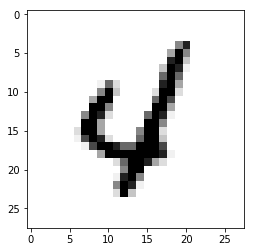

In [19]:
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

## sample 2

In [ ]:
import tensorflow as tf
import numpy as np

In [2]:
raw_data = np.random.normal(10, 1, 100) # 평균이 10이고 표준편차가 1인 100개의 랜덤 변수
alpha = tf.constant(0.05)               # 가중치 0.05
curr_value = tf.placeholder(tf.float32)
prev_avg = tf.Variable(0.)
update_avg = alpha * curr_value + (1-alpha) * prev_avg

In [3]:
# print(raw_data)

In [4]:
avg_hist = tf.summary.scalar("running_average", update_avg)
value_hist = tf.summary.scalar("incoming_values", curr_value)
summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs")

In [5]:
init = tf.global_variables_initializer()

In [6]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(len(raw_data)):
        summary_str, curr_avg = sess.run([summary, update_avg], feed_dict={curr_value:raw_data[i]})
        sess.run(tf.assign(prev_avg, curr_avg))
        writer.add_summary(summary_str, i)

In [ ]:
'''
$ tensorboard --logdir=./logs
at browser
http://localhost:6006
'''